In [2]:
import tifffile
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd


In [3]:
import cv2
import numpy as np
import tifffile as tf
import zarr as zarr
import matplotlib.pyplot as plt
import argparse
#import colour
from sklearn.cluster import KMeans
import math
from sklearn.cluster import MiniBatchKMeans
from colour import RGB_to_XYZ, SDS_ILLUMINANTS, XYZ_to_Lab, delta_E
from colour.models.rgb import RGB_COLOURSPACES, RGB_to_XYZ
#import skimage.color

In [4]:
store = tifffile.imread('/Users/lune/Education/Color/Calib_Polaris_Scan3.qptiff', aszarr=True)
zarr_pyramids = zarr.open(store, mode='r')
len(zarr_pyramids)
image = np.array(zarr_pyramids[6]) #3 for huron, #6 for polaris
image.shape

(11340, 6120, 3)

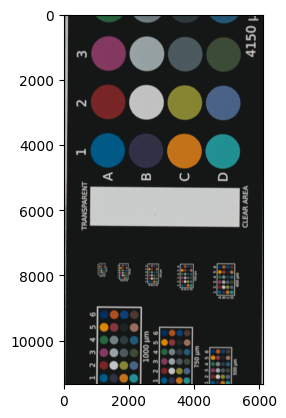

In [5]:
plt.imshow(image)

1. Image preprocessing

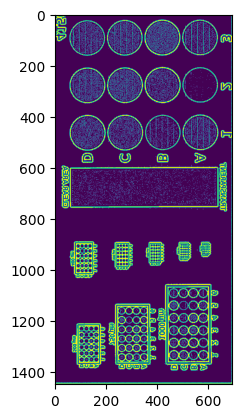

In [34]:
def image_preprocessing(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return(binary_image)

image_processed = image_preprocessing(image)
plt.imshow(image_processed)

2. Rectangle and its points (for all recognized rectangles)

In [35]:
def fing_rectangle_pts(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangle_pts = []
    for contour in contours:
        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            pts = approx.reshape(-1, 2)
            pts = np.array(pts, dtype=np.float32)
            rectangle_pts.append(pts)
            
    return(rectangle_pts)

rectangle_pts = fing_rectangle_pts(image_processed)
rectangle_pts 

[array([[ 370., 1135.],
        [ 234., 1138.],
        [ 252., 1390.],
        [ 393., 1352.]], dtype=float32),
 array([[ 607., 1058.],
        [ 429., 1062.],
        [ 455., 1395.],
        [ 636., 1341.]], dtype=float32),
 array([[637., 605.],
        [ 62., 601.],
        [ 58., 754.],
        [631., 756.]], dtype=float32),
 array([[661., 580.],
        [641., 590.],
        [641., 751.],
        [665., 773.]], dtype=float32),
 array([[401., 550.],
        [399., 579.],
        [440., 579.],
        [439., 551.]], dtype=float32),
 array([[ 692.,    0.],
        [ 688., 1442.],
        [   0., 1447.],
        [ 692., 1447.]], dtype=float32)]

3. Aligned picture (if rectangle is rotated)


we will need **src_pts** (source points), **w** and **h** - widht and height of this rectangle (based on source points) and **dst_pts** (destination points)

160.5 290.0


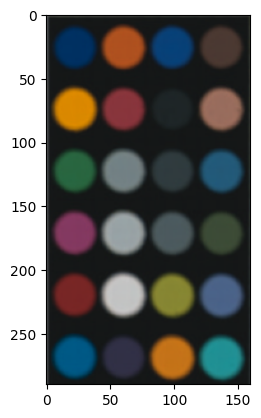

In [24]:
i = 2 # for first rectangle
src_pts = rectangle_pts[i]

def find_dst_pts(src_pts):
    w = abs((src_pts[0][0]+src_pts[1][0])/2 - (src_pts[2][0]+src_pts[3][0])/2)
    h = abs((src_pts[0][1]+src_pts[3][1])/2 - (src_pts[1][1]+src_pts[2][1])/2)
    return w,h

w, h = find_dst_pts(src_pts)
print(w, h)
dst_pts = np.array([[0, 0], [0, h],  [w, h], [w, 0]], dtype=np.float32)

# lets transform rectangle using src_pts, w, h, dst_pts
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

4. And we can also achieve aligned picture in high resolution

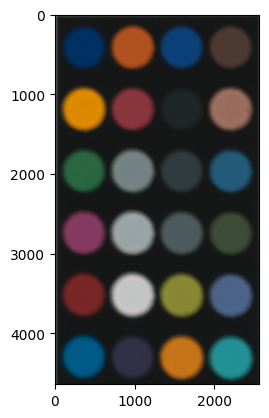

In [25]:
layer = 2 # lets go from 6 layer to 2
image_high_res = np.array(zarr_pyramids[6-(6-layer)])


# lets find src_pts, w, h, dst_pts

coef = 2**(6-layer)
src_pts = src_pts * coef #src_pts

w, h = w * coef, h * coef # w, h
dst_pts = dst_pts * coef # dst_pts

# and transform

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image_high_res, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

### How to find colors?

#### Circles

160.5 290.0


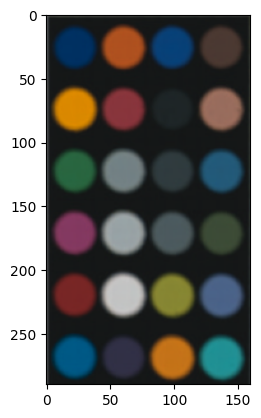

In [26]:
i = 2 # for first rectangle
src_pts = rectangle_pts[i]

def find_dst_pts(src_pts):
    w = abs((src_pts[0][0]+src_pts[1][0])/2 - (src_pts[2][0]+src_pts[3][0])/2)
    h = abs((src_pts[0][1]+src_pts[3][1])/2 - (src_pts[1][1]+src_pts[2][1])/2)
    return w,h

w, h = find_dst_pts(src_pts)
print(w, h)
dst_pts = np.array([[0, 0], [0, h],  [w, h], [w, 0]], dtype=np.float32)

# lets transform rectangle using src_pts, w, h, dst_pts
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

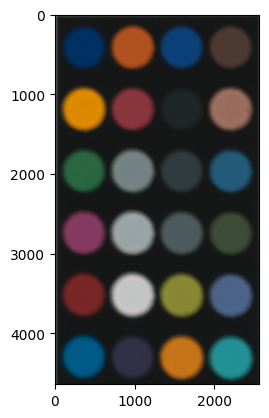

In [27]:
layer = 2 # lets go from 6 layer to 2
image_high_res = np.array(zarr_pyramids[6-(6-layer)])


# lets find src_pts, w, h, dst_pts

coef = 2**(6-layer)
src_pts = src_pts * coef #src_pts

w, h = w * coef, h * coef # w, h
dst_pts = dst_pts * coef # dst_pts

# and transform

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image_high_res, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

In [28]:
img=warp
output=img.copy()
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    

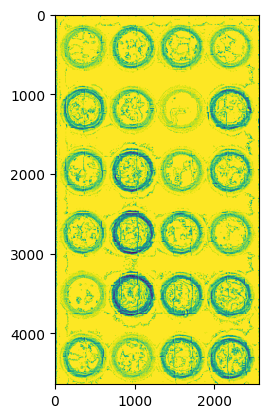

In [29]:
th = cv2.adaptiveThreshold(gray_img,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,0.1)
plt.imshow(th)

In [52]:
th.shape[1]/500

5.136

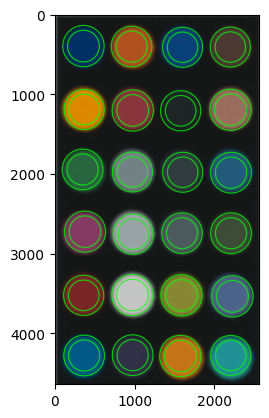

In [30]:
#findind circles by applying different settings
min_r = th.shape[1]/10.272
max_r = th.shape[1]/9.876
distance = th.shape[1]/5.136
circles = cv2.HoughCircles(th, cv2.HOUGH_GRADIENT, 1.3, distance, param2=22, param1=21, minRadius=min_r, maxRadius=max_r) #th, cv2.HOUGH_GRADIENT, 1.3, 500, param2=22, param1=21, minRadius=250, maxRadius=260
detected_circles=np.uint16(np.around(circles))

output=img.copy()
#drawing detected circles on a picture - contours are a bit displaced, so I had to manually find a distance between circle's centers on x and y axes
for (x, y, r) in detected_circles[0, :]:
    cv2.circle(output, (x, y), r, (0, 255, 0), 10) 
plt.imshow(output)

detected_circles[0, :, 2] -= 60

#drawing detected circles on a picture - contours are a bit displaced, so I had to manually find a distance between circle's centers on x and y axes
for (x, y, r) in detected_circles[0, :]:
    cv2.circle(output, (x, y), r, (0, 255, 0), 10) 
plt.imshow(output)

In [31]:
detected_circles = detected_circles[0]
detected_circles = detected_circles[np.argsort(detected_circles[:,1])]

for i in range(6):
    to_change = detected_circles[i*4:i*4+4] 
    detected_circles[i*4:i*4+4,] = to_change[np.argsort(to_change[0:4,0]),]
detected_circles

array([[ 356,  402,  199],
       [ 959,  408,  195],
       [1598,  417,  191],
       [2196,  414,  191],
       [ 365, 1197,  192],
       [ 974, 1210,  199],
       [1574, 1214,  192],
       [2198, 1201,  199],
       [ 346, 1949,  195],
       [ 970, 1981,  191],
       [1600, 1984,  191],
       [2205, 1990,  196],
       [ 376, 2729,  198],
       [ 980, 2761,  192],
       [1591, 2748,  194],
       [2205, 2749,  195],
       [ 359, 3528,  192],
       [ 970, 3524,  199],
       [1584, 3528,  198],
       [2222, 3541,  199],
       [ 365, 4282,  195],
       [ 973, 4278,  195],
       [1570, 4289,  199],
       [2202, 4282,  191]], dtype=uint16)

In [32]:
aligned_circles = detected_circles

In [33]:
colors={}
lines=['A', 'B', 'C', 'D']
#rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
line_index=0
row=1
rgb_array=np.zeros((25,3))
output = warp.copy()
for i, (x, y, r) in zip(range(1,25), aligned_circles[ :]):
    Mask = np.zeros_like(gray_img)
    cv2.circle(Mask, (x, y), r, 255, -1)
    mean_color = cv2.mean(output, mask=Mask)[:3]
    colors[str(row)+lines[line_index]] = mean_color
    rgb_array[i,:]=mean_color
    row+=1
    if i%6==0:
        line_index+=1
        row=1
    color = tuple([int(c) for c in mean_color])
#np.round(rgb_array).astype(int)

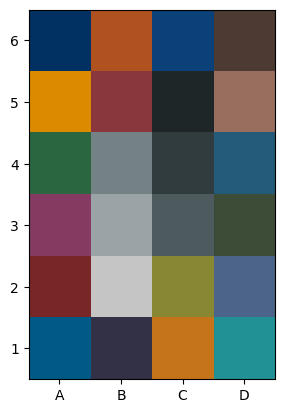

In [34]:
colors = np.round(rgb_array).astype(int)[1:].reshape(6, 4, 3)
fig, ax = plt.subplots()

ax.imshow(colors)

x_tick_positions = np.arange(0, colors.shape[1])
x_tick_labels = ["A", "B", "C", "D"]  
plt.xticks(x_tick_positions, x_tick_labels)

y_tick_positions = np.arange(0, colors.shape[0])
y_tick_labels = ["6", "5", "4", "3", "2", "1"]  
plt.yticks(y_tick_positions, y_tick_labels)

plt.show()

#### CA

641.0 174.5


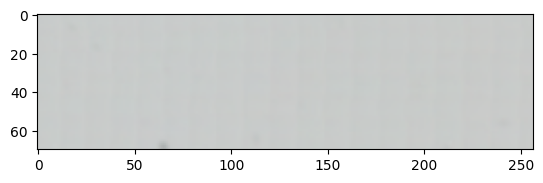

In [35]:
i = 3 # for first rectangle
src_pts = rectangle_pts[i]

def find_dst_pts(src_pts):
    w = abs((src_pts[0][0]+src_pts[1][0])/2 - (src_pts[2][0]+src_pts[3][0])/2)
    h = abs((src_pts[0][1]+src_pts[3][1])/2 - (src_pts[1][1]+src_pts[2][1])/2)
    return w,h

w, h = find_dst_pts(src_pts)
print(w, h)
dst_pts = np.array([[0, 0], [0, h],  [w, h], [w, 0]], dtype=np.float32)

# lets transform rectangle using src_pts, w, h, dst_pts
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

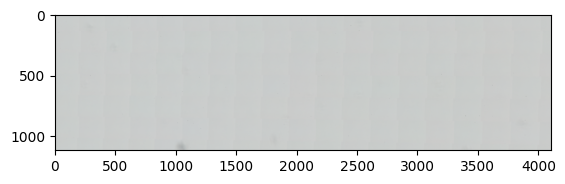

In [36]:
layer = 2 # lets go from 6 layer to 2
image_high_res = np.array(zarr_pyramids[6-(6-layer)])


# lets find src_pts, w, h, dst_pts

coef = 2**(6-layer)
src_pts = src_pts * coef #src_pts

w, h = w * coef, h * coef # w, h
dst_pts = dst_pts * coef # dst_pts

# and transform

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image_high_res, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

In [37]:
CA_rgb = np.mean(warp, axis=(0, 1))
rgb_array[0] = CA_rgb 
rgb_array_CA = np.concatenate(([rgb_array[0]],[rgb_array[0]],[rgb_array[0]],[rgb_array[0]],rgb_array[1:]))

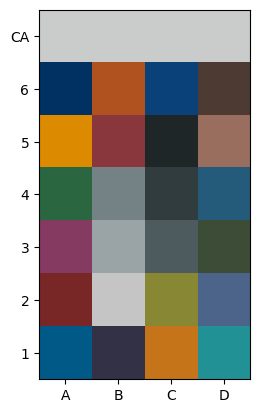

In [38]:
colors = np.round(rgb_array_CA).astype(int).reshape(7, 4, 3)
fig, ax = plt.subplots()

ax.imshow(colors)

x_tick_positions = np.arange(0, colors.shape[1])
x_tick_labels = ["A", "B", "C", "D"]  
plt.xticks(x_tick_positions, x_tick_labels)

y_tick_positions = np.arange(0, colors.shape[0])
y_tick_labels = ["CA","6", "5", "4", "3", "2", "1"]  
plt.yticks(y_tick_positions, y_tick_labels)

plt.show()

In [ ]:
# check rgb
#image = np.zeros((1, 1, 3), dtype=np.uint8)
#image[0, 0, :] = [  135.920598,  135.436327,   51.452474]
#plt.imshow(image)

In [43]:
row_names = ["CA", "A6", "B6", "C6", "D6", 
             "A5", "B5", "C5", "D5", 
             "A4", "B4", "C4", "D4", 
             "A3", "B3", "C3", "D3", 
             "A2", "B2", "C2", "D2",
             "A1", "B1", "C1", "D1"]

df = pd.DataFrame(rgb_array, columns=["R", "G", "B"], index=row_names)
print(df)

             R           G           B
CA  201.632908  204.320382  203.066300
A6    0.000000   49.086653   98.296138
B6  175.947368   81.858733   31.988228
C6    9.163479   65.326626  120.096663
D6   75.844840   57.541505   50.811843
A5  220.002047  137.611223    0.000000
B5  137.146413   53.917568   60.799905
C5   30.777813   37.735432   39.431815
D5  154.397995  109.879298   94.191010
A4   41.779851  102.510721   64.702879
B4  116.011471  130.028467  133.486072
C4   48.620219   59.735441   62.973689
D4   36.019859   90.483518  121.694718
A3  132.651278   57.742115   97.240178
B3  154.110579  163.925411  166.622088
C3   76.604578   90.519148   94.699517
D3   61.237656   75.919947   55.111100
A2  120.672373   38.834152   37.951978
B2  196.229730  196.902188  196.479149
C2  135.920598  135.436327   51.452474
D2   75.636182   99.573898  137.145649
A1    0.000000   89.489898  134.235605
B1   49.938233   48.929768   70.443378
C1  197.783608  115.803732   25.322236
D1   33.457107  145.03885

In [46]:
df.to_csv('/Users/lune/Education/Color/RGB_Calib_Polaris_Scan3') 